<div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 20px;">
    <img src="earthscope.png" alt="EarthScope Consortium Logo" style="width: 179px; margin-bottom: 30px;">
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0;">
        <img src="https://www.sci.utah.edu/images/news/2023/sci-30-multi.jpg" alt="Scientific Computing and Imaging Institute Logo" width="100"/>
    </div>
</div>

<h1 style="text-align: center; font-size: 24px; margin-top: 0;">NSF National Data Platform (NDP)</h1>
<h3 style="text-align: center; font-size: 18px; margin-top: 10px;">Streaming Data from EarthScope Consortium and One-Class SVM on data loaded from archived data</h3>

<div style="margin: 20px 0;">
    <p>EarthScope Consortium is a consortium dedicated to supporting transformative global geophysical research and education. We are a global community of hundreds of employees and tens of thousands of scientists, scholars, and educators. Our goal is to advance human understanding of the Earth and its physical systems by democratizing access to geophysical observations and practices.</p>
    <p>Note: In the current version, the producer is streaming only from station "ACSB".</p>
</div>

[EarthScope Data Policy](https://www.unavco.org/data/policies_forms/data-policy/data-policy.html)

[EarthScope Realtime Data Policy](https://www.unavco.org/data/policies_forms/data-policy/data-policy-realtime-streaming-gps/data-policy-realtime-streaming-gps.html)

<center>
    <div style="text-align: right; padding: 5px;">
        <p style="text-align: right;"><strong>Contact:</strong> Scientific and Computing Imaging Institute, University of Utah (<a href="mailto:saleem.alharir@utah.edu">saleem.alharir@utah.edu</a>)</p>
    </div>
</center>


<div style="display: flex; align-items: center; justify-content: flex-start; margin-top: 20px; border-top: 1px solid #ccc; padding-top: 20px;">
    <img src="https://new.nsf.gov/themes/custom/nsf_theme/components/images/logo/logo-desktop.svg" alt="NSF Logo" style="width: 120px; margin-right: 10px;">
    <p style="font-size: 12px;">The National Data Platform was funded by NSF 2333609 under CI, CISE Research Resources programs. Any opinions, findings, conclusions, or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the funders.</p>
</div>

<hr>

In [ ]:
pip install scikit-learn kafka-python

### One-Class SVM for anomaly detection (proof of concept)
<hr>

In [1]:
from kafka import KafkaConsumer
import json
import requests
import matplotlib.pyplot as plt
from IPython.display import clear_output
from datetime import datetime
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
CKAN_URL = 'http://ckan.geosciframe.org:5000/catalog'

def dataset_detail(dataset_name):
    """Get details of a specific dataset by name."""
    response = requests.get(f"{CKAN_URL}/api/3/action/package_show", params={"id": dataset_name})
    return response.json()

def extract_details_and_download(dataset_name):
    details = dataset_detail(dataset_name)

    # Extract bootstrap_server, topic, and file URL
    bootstrap_server = next((item['value'] for item in details['result']['extras'] if item['key'] == 'bootstrap_server'), None)
    topic = next((item['value'] for item in details['result']['extras'] if item['key'] == 'topic'), None)
    file_url = details['result'].get('url')

    print(f"Bootstrap Server: {bootstrap_server}")
    print(f"Topic: {topic}")
    print(f"File URL: {file_url}")

    # Download and save the file
    if file_url:
        response = requests.get(file_url)
        if response.status_code == 200:
            file_path = file_url.split('/')[-1]  # Extracts filename from URL
            with open(file_path, 'wb') as file:
                file.write(response.content)
            return file_path, bootstrap_server, topic
        else:
            print("Failed to download the file.")
            return None, bootstrap_server, topic
    else:
        print("No file URL found.")
        return None, bootstrap_server, topic

dataset_name = "acsb"  # Replace with an actual dataset name
file_path, bootstrap_server, topic = extract_details_and_download(dataset_name)
if file_path:
    print(f"File downloaded and saved as file_path {file_path}")

# bootstrap_server and topic are now accessible outside the function
print(f"Bootstrap Server: {bootstrap_server}")
print(f"Topic: {topic}")


Bootstrap Server: 54.145.37.197:9092
Topic: ACSB
File URL: http://ds2.datacollaboratory.org/txt_files/ACSB.PW.LY_.00.txt
File downloaded and saved as file_path ACSB.PW.LY_.00.txt
Bootstrap Server: 54.145.37.197:9092
Topic: ACSB


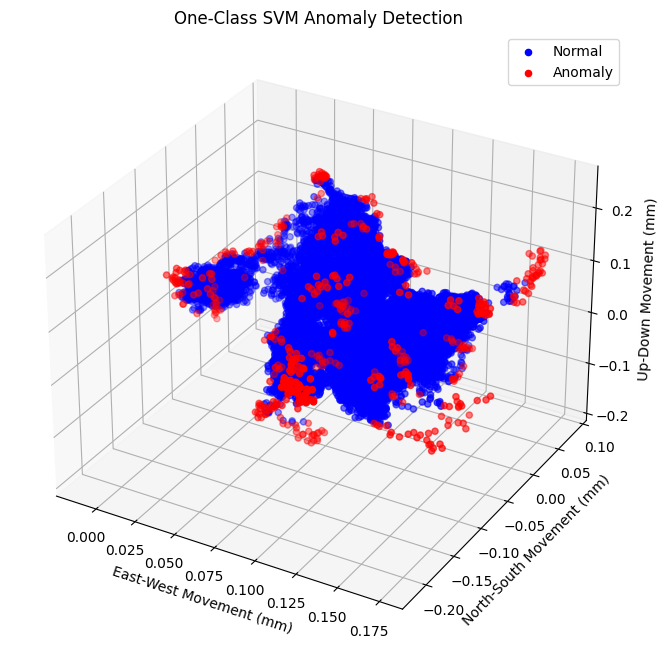

In [3]:
# Path to the downloaded file (assuming it's in the same directory as the notebook)
file_path = file_path  

# Load data from text file, taking only the first 50,000 rows
df = pd.read_csv(file_path, sep='\t', nrows=50000)

# Ensure your DataFrame has the necessary columns: 'x', 'y', 'z'
# If not, adjust the column names accordingly

# Selecting features
X = df[['x', 'y', 'z']]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)  # Adjust nu based on your requirement

# Fit the model on the data
oc_svm.fit(X_scaled)

# Predict the anomalies
y_pred = oc_svm.predict(X_scaled)

# Add predictions to the DataFrame
df['predicted_anomaly'] = y_pred

# Visualizing in 3D
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot(111, projection='3d')

# Normal data points
ax.scatter(df.loc[df['predicted_anomaly'] == 1, 'x'],
           df.loc[df['predicted_anomaly'] == 1, 'y'],
           df.loc[df['predicted_anomaly'] == 1, 'z'],
           c='blue', label='Normal')

# Anomalous data points (if any)
ax.scatter(df.loc[df['predicted_anomaly'] == -1, 'x'],
           df.loc[df['predicted_anomaly'] == -1, 'y'],
           df.loc[df['predicted_anomaly'] == -1, 'z'],
           c='red', label='Anomaly')

ax.set_xlabel('East-West Movement (mm)')
ax.set_ylabel('North-South Movement (mm)')
ax.set_zlabel('Up-Down Movement (mm)')
plt.title('One-Class SVM Anomaly Detection')
plt.legend()
plt.show()


### One-Class SVM Anomaly Detection Results

The scatter plot visualizes the outcome of an anomaly detection process using a One-Class SVM on a dataset comprising 50,000 observations "13.89 Hours". Points in the 3D space are color-coded:

- <span style="color:blue">**Blue points**</span> represent normal data instances, forming distinct clusters.
- <span style="color:red">**Red points**</span> indicate detected anomalies, which are visibly separated from the main clusters, suggesting atypical data patterns.

This form of visualization enables quick identification of outliers and provides insights into the dataset's underlying structure, guiding further investigative efforts into the anomalous observations.

<hr>


### Near Real Time Data visualization
##### PS : this is simple visualization using Matplotlib and IPython display it can be more complex but this is a proof of concept
##### Note: In the current version, the producer is streaming only from station "ACSB".
<hr>

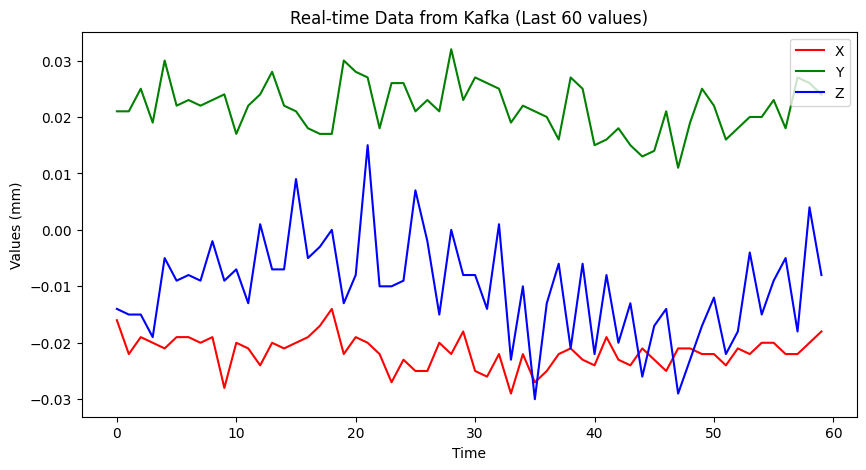

Stopping consumer...


In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from kafka import KafkaConsumer
import json
from datetime import datetime

# Initialize Kafka consumer
consumer = KafkaConsumer(
    topic,  # your topic name
    bootstrap_servers=[bootstrap_server],
    #auto_offset_reset='earliest',
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))
)

# Function to update plot
def update_plot(x_vals, y_vals, z_vals):
    # Keep only the last 60 values
    x_vals = x_vals[-60:]
    y_vals = y_vals[-60:]
    z_vals = z_vals[-60:]

    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, label='X', color='red')
    plt.plot(y_vals, label='Y', color='green')
    plt.plot(z_vals, label='Z', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Values (mm)')
    plt.title('Real-time Data from Kafka (Last 60 values)')
     # Fix the legend position to the upper right
    plt.legend(loc='upper right')

    plt.show()

# Lists to hold data
x_vals = []
y_vals = []
z_vals = []

# Process messages
try:
    for message in consumer:
        message_value = message.value

        # Extract values
        x = float(message_value['x'])
        y = float(message_value['y'])
        z = float(message_value['z'])

        # Append to lists
        x_vals.append(x)
        y_vals.append(y)
        z_vals.append(z)

        # Update plot
        clear_output(wait=True)
        update_plot(x_vals, y_vals, z_vals)

except KeyboardInterrupt:
    print("Stopping consumer...")
finally:
    consumer.close()
